In [1]:
from google.colab import drive
from os.path import join
ROOT = "/content/drive"
print(ROOT)
drive.mount(ROOT)

/content/drive
Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Learning_spoon/test_lectrue

/content/drive/MyDrive/Learning_spoon/test_lectrue


In [3]:
!pwd

/content/drive/MyDrive/Learning_spoon/test_lectrue


In [4]:
!pip install ttach

In [5]:
import pytorch_grad_cam

In [ ]:
# !git clone https://github.com/cook-leature/Bio_deep_learning_lecture_test.git

In [ ]:
!pwd

/content/drive/MyDrive/Learning_spoon/test_lectrue


In [ ]:
# !wget -O histology_dataset.zip --no-check-certificate https://zenodo.org/record/53169/files/Kather_texture_2016_image_tiles_5000.zip?download=1

In [ ]:
# !wget -O histology_image_5000_5000.zip --no-check-certificate https://zenodo.org/record/53169/files/Kather_texture_2016_larger_images_10.zip?download=1

In [ ]:
# !unzip histology_dataset.zip

In [ ]:
# !unzip histology_image_5000_5000.zip

In [ ]:
import os

In [ ]:
def print_files_in_dir(root_dir, prefix):
    files = os.listdir(root_dir)
    for file in files:
        path = os.path.join(root_dir, file)
        file_list = os.listdir(path)
        print(f"해당 Class 폴더의 이름은 {prefix + path}")
        print(f"해당 폴더의 데이터의 수는 {len(file_list)}")

In [ ]:
print_files_in_dir("Kather_texture_2016_image_tiles_5000", "")

해당 Class 폴더의 이름은 Kather_texture_2016_image_tiles_5000/01_TUMOR
해당 폴더의 데이터의 수는 625
해당 Class 폴더의 이름은 Kather_texture_2016_image_tiles_5000/02_STROMA
해당 폴더의 데이터의 수는 625
해당 Class 폴더의 이름은 Kather_texture_2016_image_tiles_5000/03_COMPLEX
해당 폴더의 데이터의 수는 625
해당 Class 폴더의 이름은 Kather_texture_2016_image_tiles_5000/04_LYMPHO
해당 폴더의 데이터의 수는 625
해당 Class 폴더의 이름은 Kather_texture_2016_image_tiles_5000/05_DEBRIS
해당 폴더의 데이터의 수는 625
해당 Class 폴더의 이름은 Kather_texture_2016_image_tiles_5000/06_MUCOSA
해당 폴더의 데이터의 수는 625
해당 Class 폴더의 이름은 Kather_texture_2016_image_tiles_5000/07_ADIPOSE
해당 폴더의 데이터의 수는 625
해당 Class 폴더의 이름은 Kather_texture_2016_image_tiles_5000/08_EMPTY
해당 폴더의 데이터의 수는 625


In [ ]:
def create_dir(dir_name : str):
  if not os.path.exists(dir_name):
      os.makedirs(dir_name)

In [ ]:
create_dir("training_dataset")

In [ ]:
create_dir("validation_dataset")

In [ ]:
files = os.listdir("Kather_texture_2016_image_tiles_5000")

In [ ]:
files.sort()

In [ ]:
for class_name in files:
  train_sub_folder_path = os.path.join("training_dataset", class_name)
  create_dir(train_sub_folder_path)
  val_sub_folder_path = os.path.join("validation_dataset", class_name)
  create_dir(val_sub_folder_path)


In [ ]:
image_file_root = "Kather_texture_2016_image_tiles_5000"

In [ ]:
train_dataset_folder = "training_dataset"
val_dataset_folder = "validation_dataset"

In [ ]:
import random
from shutil import copyfile


In [ ]:
for class_name in files:
  image_files = os.listdir(os.path.join(image_file_root, class_name))
  random.shuffle(image_files)
  train_image_list = image_files[:500]
  val_image_list = image_files[500:]

  

  for train_image in train_image_list:
    copyfile(os.path.join(image_file_root, class_name, train_image), os.path.join(train_dataset_folder, class_name, train_image))
  for val_image in val_image_list:
    copyfile(os.path.join(image_file_root, class_name, val_image), os.path.join(val_dataset_folder, class_name, val_image))
  

In [6]:
import torch
from torchvision import datasets, models, transforms

from torchvision.models import resnet50

from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
# from nets import *
import time, os, copy, argparse
import multiprocessing
from torchsummary import summary
from matplotlib import pyplot as plt

import cv2
import numpy as np


import torch.utils.data as data


In [7]:
# Batch size
bs = 32 
# Number of epochs
num_epochs = 20

# Number of classes
num_classes = 8

In [8]:
# Applying transforms to the data
image_transforms = { 
    'train': transforms.Compose([
        transforms.Resize(size=224),
        transforms.ToTensor(),
        transforms.RandomRotation(90, expand=False),
        transforms.RandomRotation(180, expand=False),
        transforms.RandomRotation(270, expand=False),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}
 
    

In [9]:
    
train_directory = './training_dataset'
valid_directory = './validation_dataset'
# Set the model save path
PATH="model.pth" 
    

In [10]:
# Load data from folders
dataset = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid'])
}
 
    
    
# Size of train and validation data
dataset_sizes = {
    'train':len(dataset['train']),
    'valid':len(dataset['valid'])
}


# Create iterators for data loading
dataloaders = {
    'train':data.DataLoader(dataset['train'], batch_size=bs, shuffle=True,
                            num_workers=4, pin_memory=True, drop_last=False),
    'valid':data.DataLoader(dataset['valid'], batch_size=bs, shuffle=True,
                            num_workers=4, pin_memory=True, drop_last=False)
}



# Class names or target labels
class_names = dataset['train'].classes
print("Classes:", class_names)



 # Print the train and validation data sizes
print("Training-set size:",dataset_sizes['train'],
      "\nValidation-set size:", dataset_sizes['valid'])

Classes: ['01_TUMOR', '02_STROMA', '03_COMPLEX', '04_LYMPHO', '05_DEBRIS', '06_MUCOSA', '07_ADIPOSE', '08_EMPTY']
Training-set size: 4000 
Validation-set size: 1000


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [11]:
# Set default device as gpu, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = resnet50(pretrained=True)
# target_layers = [model.layer4[-1]]

model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, num_classes))


# model.load_state_dict(torch.load("histopathology_model/histopathology_model.pt"))

model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [12]:
device

device(type='cuda', index=0)

In [13]:
criterion = nn.CrossEntropyLoss()

In [14]:
# Optimizer 
optimizer_ft = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

# Learning rate decay
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Model training routine 
print("\nTraining:-\n")


Training:-



In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Tensorboard summary
    writer = SummaryWriter()
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Record training loss and accuracy for each phase
            if phase == 'train':
                writer.add_scalar('Train/Loss', epoch_loss, epoch)
                writer.add_scalar('Train/Accuracy', epoch_acc, epoch)
                writer.flush()
            else:
                writer.add_scalar('Valid/Loss', epoch_loss, epoch)
                writer.add_scalar('Valid/Accuracy', epoch_acc, epoch)
                writer.flush()

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [17]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.2544 Acc: 0.9143
valid Loss: 0.3695 Acc: 0.8840

Epoch 1/4
----------
train Loss: 0.2200 Acc: 0.9297
valid Loss: 0.2223 Acc: 0.9210

Epoch 2/4
----------
train Loss: 0.1876 Acc: 0.9343
valid Loss: 0.2635 Acc: 0.9110

Epoch 3/4
----------
train Loss: 0.1711 Acc: 0.9405
valid Loss: 0.2170 Acc: 0.9220

Epoch 4/4
----------
train Loss: 0.1494 Acc: 0.9495
valid Loss: 0.2451 Acc: 0.9280

Training complete in 4m 19s
Best val Acc: 0.928000


In [18]:
pred_all =[]
label_all = []

In [19]:
for index , (inputs, labels) in enumerate(dataloaders["valid"]):
  inputs = inputs.to(device, non_blocking=True)
  labels = labels.to(device, non_blocking=True)

  pred = model(inputs)
  pred = pred.cpu().detach().numpy()

  if index == 0:
    all_pred = pred
  else:
    all_pred = np.append(all_pred, pred, axis = 0)

  pred_all.extend(pred)

  labels = labels.cpu().detach().numpy().tolist()
  label_all.extend(labels)



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [20]:
all_pred.shape

(1000, 8)

In [21]:
len(label_all)

1000

In [26]:
from sklearn.metrics import classification_report

In [27]:
all_pred_argmax = np.argmax(all_pred, axis=1)

In [29]:
target_names = ['01_TUMOR', '02_STROMA', '03_COMPLEX', '04_LYMPHO', '05_DEBRIS', '06_MUCOSA', '07_ADIPOSE', '08_EMPTY']

In [30]:
print(classification_report(label_all, all_pred_argmax, target_names=target_names))

              precision    recall  f1-score   support

    01_TUMOR       0.98      0.98      0.98       125
   02_STROMA       0.98      0.74      0.84       125
  03_COMPLEX       0.86      0.86      0.86       125
   04_LYMPHO       0.93      0.92      0.93       125
   05_DEBRIS       0.83      0.98      0.90       125
   06_MUCOSA       0.93      1.00      0.96       125
  07_ADIPOSE       0.99      0.94      0.97       125
    08_EMPTY       0.95      1.00      0.97       125

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



In [55]:
torch.save(model.state_dict(), "model.pt")


In [56]:
model.load_state_dict(torch.load("model.pt"))

<All keys matched successfully>

## 큰 타일 이미지 Load

In [57]:
!pwd

/content/drive/MyDrive/Learning_spoon/test_lectrue


In [58]:
target_image = cv2.imread("/content/drive/MyDrive/Learning_spoon/test_lectrue/Kather_texture_2016_larger_images_10/CRC-Prim-HE-07_APPLICATION.tif")

In [59]:
type(target_image)

numpy.ndarray

In [60]:
target_image.shape

(5000, 5000, 3)

In [61]:
slide_x_size = target_image.shape[1]
slide_y_size = target_image.shape[0]


In [62]:
step_x = 150
step_y = 150

In [63]:
step_num_x = int(slide_x_size/step_x)
step_num_y = int(slide_y_size/step_y)

In [64]:
image_split_list = []

for y_index in range(0, step_num_y):
    for x_index in range(0, step_num_x):
        temp_image = target_image[step_y * y_index : step_y * (y_index + 1), step_x * x_index : step_x * (x_index + 1)]
        image_split_list.append(temp_image)
        

In [65]:
from google.colab.patches import cv2_imshow

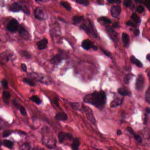

In [66]:
cv2_imshow(image_split_list[0])

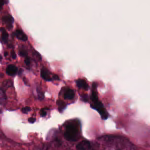

In [67]:
cv2_imshow(image_split_list[1])

In [88]:
total_image_resize = cv2.resize(target_image, dsize = (1000, 1000))

In [69]:
cv2_imshow(total_image_resize)

Output hidden; open in https://colab.research.google.com to view.

In [71]:
from torch.utils.data import Dataset, DataLoader


class Image_Array_list_test_Dataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        
        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8))
            x = self.transform(x)
        
        return x
    
    def __len__(self):
        return len(self.data)

In [72]:
test_Dataset = Image_Array_list_test_Dataset(image_split_list, transform=image_transforms['valid'])

test_dataloader = DataLoader(test_Dataset, batch_size=32)

In [73]:
from tqdm import tqdm

In [74]:
model = model.eval()

In [75]:
label_list = []

In [76]:
from PIL import Image

In [77]:
for inputs in tqdm(test_dataloader):
  inputs = inputs.to(device, non_blocking=True)
  outputs = model(inputs)
  outputs = outputs.cpu().detach().numpy()
  label_list.extend(np.argmax(outputs, 1).tolist())
  

100%|██████████| 35/35 [00:05<00:00,  6.86it/s]


In [78]:
image_max = 255

image_mask_color_list =  [np.array([231 / image_max, 74 / image_max, 23 /image_max]),
    np.array([68 / image_max, 171 / image_max, 36 /image_max]),
    np.array([247 / image_max, 187 / image_max, 9/image_max]),
    np.array([132 / image_max, 207 / image_max, 199 /image_max]),
    np.array([189 / image_max, 40 / image_max, 153 /image_max]),
    np.array([251 / image_max, 218 / image_max, 203 /image_max]),
    np.array([142 / image_max, 142 / image_max, 142 /image_max]),
    np.array([53 / image_max, 53 / image_max, 53 /image_max])
     
    ]

In [79]:
def apply_mask_image(image, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    new_image = np.zeros((image.shape[0], image.shape[1], 3))
    
    for c in range(3):
        new_image[:, :, c] = image[:, :, c] * (1 - alpha) + alpha * image_mask_color_list[color][c] * 255
    
    return new_image



In [80]:
out_result_image_list = []

In [87]:
label_list

[5,
 5,
 7,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 7,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 5,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 5,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 4,
 4,
 4,
 1,
 1,
 4,
 4,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [81]:
for index, seg_label_image in enumerate(tqdm(label_list)):
  new_image = apply_mask_image(image_split_list[index], label_list[index])
  out_result_image_list.append(new_image)


100%|██████████| 1089/1089 [00:00<00:00, 1681.35it/s]


In [82]:
def image_crop_list_to_total_image(image_array_list, step_y, step_x, step_num_y, step_num_x):
  if len(image_array_list) != step_num_y * step_num_x:
    raise Exception('length of image_Array_list is not same to step_num_y X step_num_X')
  temp_array = np.zeros((step_y * step_num_y, step_x * step_num_x, 3), dtype=np.uint8)
  cnt = 0
  for y_index in range(0, step_num_y):
      for x_index in range(0, step_num_x):
          temp_array[step_y * y_index : step_y * (y_index + 1), step_x * x_index : step_x * (x_index + 1)] = image_array_list[cnt]
          cnt += 1
  out_image_array = temp_array
  return out_image_array
    

In [83]:
final_output = image_crop_list_to_total_image(out_result_image_list, step_y, step_x, step_num_y, step_num_x )

In [84]:
final_output_resize = cv2.resize(final_output, dsize = (1000, 1000))

In [85]:
cv2_imshow(final_output_resize)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import cv2
import numpy as np
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image


In [ ]:
# !pip install git+https://github.com/jacobgil/pytorch-grad-cam.git

In [ ]:
target_layers =  [model.layer4[-1]]

In [ ]:
cam = GradCAM(model=model, target_layers=target_layers)


In [ ]:
import cv2

In [ ]:
target_image = cv2.imread("/content/Kather_texture_2016_image_tiles_5000/01_TUMOR/10009_CRC-Prim-HE-03_009.tif_Row_301_Col_151.tif")

In [ ]:
target_image.shape

(150, 150, 3)

In [ ]:
target_image_resize = cv2.resize(target_image, (224, 244))


In [ ]:
target_image_resize.shape

(244, 224, 3)

In [ ]:
target_image_resize_tensor = torch.Tensor(target_image_resize).to(device)

In [ ]:
target_image_resize_tensor = torch.permute(target_image_resize_tensor, (2, 0, 1))

In [ ]:
target_image_resize_tensor =  torch.unsqueeze(target_image_resize_tensor, 0)

In [ ]:
grayscale_cam = cam(input_tensor=target_image_resize_tensor, target_category = 4)


In [ ]:
grayscale_cam

array([[[0.42670172, 0.42670172, 0.42670172, ..., 0.5927784 ,
         0.5927784 , 0.5927784 ],
        [0.42670172, 0.42670172, 0.42670172, ..., 0.5927784 ,
         0.5927784 , 0.5927784 ],
        [0.42670172, 0.42670172, 0.42670172, ..., 0.5927784 ,
         0.5927784 , 0.5927784 ],
        ...,
        [0.12774108, 0.12774108, 0.12774108, ..., 0.3814995 ,
         0.3814995 , 0.3814995 ],
        [0.12774108, 0.12774108, 0.12774108, ..., 0.3814995 ,
         0.3814995 , 0.3814995 ],
        [0.12774108, 0.12774108, 0.12774108, ..., 0.3814995 ,
         0.3814995 , 0.3814995 ]]], dtype=float32)

In [ ]:
num_classes

8